# **Install & Importing Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vaderSentiment
!pip install sastrawi
!pip install swifter
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
import swifter

warnings.filterwarnings("ignore")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Preprocessing**

## **1. Load Dataset**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data_resources/ulasan_kebun_binatang.csv")
df

,Username,Rating,Ulasan
0,Rahmi Lianingsih,4 bintang,Pertama kali ajak anak kesini. Cocok untuk ana...
1,Nurul Muharromiyah,5 bintang,"Tempat edu wisata keluarga, bawa makanan apapu..."
2,Jianata Inanggayu Purnanean,5 bintang,Hampir setiap hari ramai dipadati pengunjung y...
3,liyaliyu oye,4 bintang,Berkunjung ke KBS tak perlu lagi pake aplikasi...
4,Kalmasera Subiakto,3 bintang,"Tiket masuk 15 ribu per kepala, anak diatas us..."
...,...,...,...
275,Hariz S,4 bintang,"Bon bin sangat oke, untuk 15rb di weekend sang..."
276,karnizayn official,5 bintang,"Tiket Masuk 15k/ orang, anak dibawah 2 Tahun t..."
277,Deya Deshinta,5 bintang,"Murah. Tiket masuk 15k, bayar pake qris. Tiket..."
278,fery syarifuddin,4 bintang,"Untuk kebersihan kebun nya di jaga, harga tike..."


In [ ]:
df.shape

(280, 3)

In [ ]:
# cek duplikat
cekduplikat = df['Ulasan'].duplicated()
cekduplikat

0      False
1      False
2      False
3      False
4      False
       ...  
275    False
276    False
277    False
278    False
279    False
Name: Ulasan, Length: 280, dtype: bool

## **2. Pelebelan Dataset**
0 = Positif  
1 = Netral  
2 = Negatif  

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to label the sentiment using VADER
def label_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return 0
    elif compound_score <= -0.05:
        return 2
    else:
        return 1

# Apply the labeling function to the dataset
df['sentiment'] = df['Ulasan'].apply(label_sentiment)

# Save the labeled dataset
df.to_csv('labeled_ulasan.csv', index=False)
df = pd.read_csv("labeled_ulasan.csv")

In [ ]:
# Count the occurrences of each label
label_counts = df['sentiment'].value_counts()

# Display the label counts
print(label_counts)

1    963
0    149
2     28
Name: sentiment, dtype: int64


## **3. Case Folding**

Case folding dilakukan pengubahan seluruh huruf menjadi kecil (lowercase) yang ada pada dokumen. Tahap ini akan dibantu dengan bantuan library RegEx.

In [ ]:
def cleaningulasan(ulasan):
  ulasan = re.sub(r'@[A-Za-a0-9]+',' ',ulasan)
  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r'http\S+',' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan
df['Cleaning']= df['Ulasan'].apply(cleaningulasan)

In [ ]:
df[['Username','Ulasan','Cleaning', 'sentiment']]

,Username,Ulasan,Cleaning,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,1
...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,1
1138,indra jenggo94,Rekreasi untuk keluarga..nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,1


In [ ]:
def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')
# kolom baru = ulasan emoji
df['HapusEmoji']= df['Cleaning'].apply(clearEmoji)

# fungsi menggantikan tiga atau lebih karakter berulang dalam teks dengan hanya satu kemunculan karakter
def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)
df['3/Lebih']= df['HapusEmoji'].apply(replaceTOM)

def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan
df['CaseFolding']= df['3/Lebih'].apply(casefoldingText)

In [ ]:
df[['Username','Ulasan','Cleaning','HapusEmoji','3/Lebih','CaseFolding','sentiment']]

,Username,Ulasan,Cleaning,HapusEmoji,3/Lebih,CaseFolding,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,pertama kali ajak anak kesini cocok untuk ana...,1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,tempat edu wisata keluarga bawa makanan apapu...,0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,hampir setiap hari ramai dipadati pengunjung y...,1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,berkunjung ke kbs tak perlu lagi pake aplikasi...,1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usia ...,tiket masuk ribu per kepala anak diatas usia ...,1
...,...,...,...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke akuari...,lebih cantik htm nya kalau mau masuk ke akuari...,1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,salah satu tempat wisata yang ramai terutama k...,1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,kebun binatang surabaya adalah salah satu kebu...,1
1138,indra jenggo94,Rekreasi untuk keluarga..nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,rekreasi untuk keluarga nyaman dan menyenenan...,1


## **4. Tokenizing**

Hasil proses case folding, kalimat akan diproses dengan menguraikannya menjadi token-token atau kata-kata. Pada tahap ini akan dibantu dengan library NLTK.

In [ ]:
def tokenizingText(ulasan):
  ulasan = word_tokenize(ulasan)
  return ulasan
df['Tokenizing']= df['CaseFolding'].apply(tokenizingText)

In [ ]:
df[['Username','Ulasan','Cleaning','HapusEmoji','3/Lebih','CaseFolding', 'Tokenizing', 'sentiment']]

,Username,Ulasan,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Tokenizing,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,pertama kali ajak anak kesini cocok untuk ana...,"[pertama, kali, ajak, anak, kesini, cocok, unt...",1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,tempat edu wisata keluarga bawa makanan apapu...,"[tempat, edu, wisata, keluarga, bawa, makanan,...",0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,hampir setiap hari ramai dipadati pengunjung y...,"[hampir, setiap, hari, ramai, dipadati, pengun...",1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,berkunjung ke kbs tak perlu lagi pake aplikasi...,"[berkunjung, ke, kbs, tak, perlu, lagi, pake, ...",1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usia ...,tiket masuk ribu per kepala anak diatas usia ...,"[tiket, masuk, ribu, per, kepala, anak, diatas...",1
...,...,...,...,...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke akuari...,lebih cantik htm nya kalau mau masuk ke akuari...,"[lebih, cantik, htm, nya, kalau, mau, masuk, k...",1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,salah satu tempat wisata yang ramai terutama k...,"[salah, satu, tempat, wisata, yang, ramai, ter...",1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,kebun binatang surabaya adalah salah satu kebu...,"[kebun, binatang, surabaya, adalah, salah, sat...",1
1138,indra jenggo94,Rekreasi untuk keluarga..nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,rekreasi untuk keluarga nyaman dan menyenenan...,"[rekreasi, untuk, keluarga, nyaman, dan, menye...",1


## **5. Formalisasi**

Tahap formalisasi dilakukan untuk pengubah penggunaan kata tidak baku menjadi baku sesuai dengan KBBI. Proses akan menggunakan file dataset slangwords yang berisi kata slang yang nanti akan diubah menjadi baku. Tahap ini dibantu dengan library RegEx. 

In [ ]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("/content/drive/MyDrive/data_resources/slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in ulasan:
        filterSlang = pattern.sub(lambda x: kamusSlang[x.group()],kata)
        content.append(filterSlang.lower())
    ulasan = content
    return ulasan
df['Formalisasi'] = df['Tokenizing'].apply(convertToSlangword)
# ulasan['Formalisasi'] = ulasan['Tokenizing'].apply(lambda x: ' '.join(x))


In [ ]:
df[['Username','Ulasan','Cleaning','HapusEmoji','3/Lebih','CaseFolding', 'Tokenizing', 'Formalisasi', 'sentiment']]

,Username,Ulasan,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Tokenizing,Formalisasi,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,pertama kali ajak anak kesini cocok untuk ana...,"[pertama, kali, ajak, anak, kesini, cocok, unt...","[pertama, kali, ajak, anak, kesini, cocok, unt...",1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,tempat edu wisata keluarga bawa makanan apapu...,"[tempat, edu, wisata, keluarga, bawa, makanan,...","[tempat, edu, wisata, keluarga, bawa, makanan,...",0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,hampir setiap hari ramai dipadati pengunjung y...,"[hampir, setiap, hari, ramai, dipadati, pengun...","[hampir, setiap, hari, ramai, dipadati, pengun...",1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,berkunjung ke kbs tak perlu lagi pake aplikasi...,"[berkunjung, ke, kbs, tak, perlu, lagi, pake, ...","[berkunjung, ke, kbs, tidak, perlu, lagi, paka...",1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usia ...,tiket masuk ribu per kepala anak diatas usia ...,"[tiket, masuk, ribu, per, kepala, anak, diatas...","[tiket, masuk, ribu, per, kepala, anak, diatas...",1
...,...,...,...,...,...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke akuari...,lebih cantik htm nya kalau mau masuk ke akuari...,"[lebih, cantik, htm, nya, kalau, mau, masuk, k...","[lebih, cantik, htm, nya, kalau, mau, masuk, k...",1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,salah satu tempat wisata yang ramai terutama k...,"[salah, satu, tempat, wisata, yang, ramai, ter...","[salah, satu, tempat, wisata, yang, ramai, ter...",1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,kebun binatang surabaya adalah salah satu kebu...,"[kebun, binatang, surabaya, adalah, salah, sat...","[kebun, binatang, surabaya, adalah, salah, sat...",1
1138,indra jenggo94,Rekreasi untuk keluarga..nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,rekreasi untuk keluarga nyaman dan menyenenan...,"[rekreasi, untuk, keluarga, nyaman, dan, menye...","[rekreasi, untuk, keluarga, nyaman, dan, menye...",1


## **6. Stopword Removal**

Hasil proses formalisasi kemudian akan dilakukan seleksi kata yang tidak penting dan menghapus kata tersebut. Tahap ini dibantu dengan library NLTK.

In [ ]:
nltk.download('stopwords')
daftar_stopword = stopwords.words('indonesian')
# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
daftar_stopword.extend(["yg","dg","rt"])
daftar_stopword = set(daftar_stopword)

def stopwordText(words):
 return [word for word in words if word not in daftar_stopword]

df['Stopword Removal'] = df['Formalisasi'].apply(stopwordText)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df[['Username','Ulasan','Cleaning','HapusEmoji','3/Lebih','CaseFolding', 'Tokenizing', 'Formalisasi', 'Stopword Removal','sentiment']]

,Username,Ulasan,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Tokenizing,Formalisasi,Stopword Removal,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,pertama kali ajak anak kesini cocok untuk ana...,"[pertama, kali, ajak, anak, kesini, cocok, unt...","[pertama, kali, ajak, anak, kesini, cocok, unt...","[kali, ajak, anak, kesini, cocok, anak, umur, ...",1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,tempat edu wisata keluarga bawa makanan apapu...,"[tempat, edu, wisata, keluarga, bawa, makanan,...","[tempat, edu, wisata, keluarga, bawa, makanan,...","[edu, wisata, keluarga, bawa, makanan, apapun,...",0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,hampir setiap hari ramai dipadati pengunjung y...,"[hampir, setiap, hari, ramai, dipadati, pengun...","[hampir, setiap, hari, ramai, dipadati, pengun...","[ramai, dipadati, pengunjung, keluarga, study,...",1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,berkunjung ke kbs tak perlu lagi pake aplikasi...,"[berkunjung, ke, kbs, tak, perlu, lagi, pake, ...","[berkunjung, ke, kbs, tidak, perlu, lagi, paka...","[berkunjung, kbs, pakai, aplikasi, tiketwisata...",1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usia ...,tiket masuk ribu per kepala anak diatas usia ...,"[tiket, masuk, ribu, per, kepala, anak, diatas...","[tiket, masuk, ribu, per, kepala, anak, diatas...","[tiket, masuk, ribu, kepala, anak, diatas, usi...",1
...,...,...,...,...,...,...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke akuari...,lebih cantik htm nya kalau mau masuk ke akuari...,"[lebih, cantik, htm, nya, kalau, mau, masuk, k...","[lebih, cantik, htm, nya, kalau, mau, masuk, k...","[cantik, htm, nya, masuk, akuarium, bayar]",1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,salah satu tempat wisata yang ramai terutama k...,"[salah, satu, tempat, wisata, yang, ramai, ter...","[salah, satu, tempat, wisata, yang, ramai, ter...","[salah, wisata, ramai, libur, wisata, cocok, e...",1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,kebun binatang surabaya adalah salah satu kebu...,"[kebun, binatang, surabaya, adalah, salah, sat...","[kebun, binatang, surabaya, adalah, salah, sat...","[kebun, binatang, surabaya, salah, kebun, bina...",1
1138,indra jenggo94,Rekreasi untuk keluarga..nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,Rekreasi untuk keluarga nyaman dan menyenenan...,rekreasi untuk keluarga nyaman dan menyenenan...,"[rekreasi, untuk, keluarga, nyaman, dan, menye...","[rekreasi, untuk, keluarga, nyaman, dan, menye...","[rekreasi, keluarga, nyaman, menyenenangkan, m...",1


## **7. Stemming**

Proses stemming dilakukan perubahan kata yang berimbuhan menjadi kata dasar. Tahap ini dibantu dengan library Sastrawi dan Swifter.

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['Stopword Removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
def stemmingText(document):
    return [term_dict[term] for term in document]

df['Stemming'] = df['Stopword Removal'].swifter.apply(stemmingText)
df['Stemming'] = df['Stopword Removal'].apply(lambda x: ','.join(x))

kali : kali
ajak : ajak
anak : anak
kesini : kesini
cocok : cocok
umur : umur
diatas : atas
th : th
dibawah : bawah
menikmati : nikmat
anakku : anak
usia : usia
rasaku : rasa
pas : pas
antusias : antusias
melihan : melihan
jenis : jenis
binatang : binatang
edu : edu
wisata : wisata
keluarga : keluarga
bawa : bawa
makanan : makan
apapun : apa
tikar : tikar
g : g
iya : iya
gaes : gaes
disediakan : sedia
duduk : duduk
menunggu : tunggu
istirahat : istirahat
buka : buka
bekal : bekal
ramai : ramai
dipadati : padat
pengunjung : unjung
study : study
tour : tour
menemani : tani
rombongan : rombong
tk : tk
sd : sd
pembaharuan : baharu
pembangunannya : bangun
bagus : bagus
berkunjung : kunjung
kbs : kbs
pakai : pakai
aplikasi : aplikasi
tiketwisata : tiketwisata
surabaya : surabaya
sdh : sdh
dibeli : beli
langsung : langsung
loket : loket
animo : animo
masyarakat : masyarakat
mengajak : ajak
buah : buah
hati : hati
satwa : satwa
koleksi : koleksi
tiket : tiket
masuk : masuk
unta : unta
ribu : r

Pandas Apply:   0%|          | 0/1140 [00:00<?, ?it/s]

In [ ]:
df[['Username','Ulasan','Cleaning','HapusEmoji','3/Lebih','CaseFolding', 'Tokenizing', 'Formalisasi', 'Stopword Removal', 'Stemming', 'sentiment']]

,Username,Ulasan,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Tokenizing,Formalisasi,Stopword Removal,Stemming,sentiment
0,Rahmi Lianingsih,Pertama kali ajak anak kesini. Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,Pertama kali ajak anak kesini Cocok untuk ana...,pertama kali ajak anak kesini cocok untuk ana...,"[pertama, kali, ajak, anak, kesini, cocok, unt...","[pertama, kali, ajak, anak, kesini, cocok, unt...","[kali, ajak, anak, kesini, cocok, anak, umur, ...","kali,ajak,anak,kesini,cocok,anak,umur,diatas,t...",1
1,Nurul Muharromiyah,"Tempat edu wisata keluarga, bawa makanan apapu...",Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,Tempat edu wisata keluarga bawa makanan apapu...,tempat edu wisata keluarga bawa makanan apapu...,"[tempat, edu, wisata, keluarga, bawa, makanan,...","[tempat, edu, wisata, keluarga, bawa, makanan,...","[edu, wisata, keluarga, bawa, makanan, apapun,...","edu,wisata,keluarga,bawa,makanan,apapun,tikar,...",0
2,Jianata Inanggayu Purnanean,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,Hampir setiap hari ramai dipadati pengunjung y...,hampir setiap hari ramai dipadati pengunjung y...,"[hampir, setiap, hari, ramai, dipadati, pengun...","[hampir, setiap, hari, ramai, dipadati, pengun...","[ramai, dipadati, pengunjung, keluarga, study,...","ramai,dipadati,pengunjung,keluarga,study,tour,...",1
3,liyaliyu oye,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,Berkunjung ke KBS tak perlu lagi pake aplikasi...,berkunjung ke kbs tak perlu lagi pake aplikasi...,"[berkunjung, ke, kbs, tak, perlu, lagi, pake, ...","[berkunjung, ke, kbs, tidak, perlu, lagi, paka...","[berkunjung, kbs, pakai, aplikasi, tiketwisata...","berkunjung,kbs,pakai,aplikasi,tiketwisata,sura...",1
4,Kalmasera Subiakto,"Tiket masuk 15 ribu per kepala, anak diatas us...",Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usi...,Tiket masuk ribu per kepala anak diatas usia ...,tiket masuk ribu per kepala anak diatas usia ...,"[tiket, masuk, ribu, per, kepala, anak, diatas...","[tiket, masuk, ribu, per, kepala, anak, diatas...","[tiket, masuk, ribu, kepala, anak, diatas, usi...","tiket,masuk,ribu,kepala,anak,diatas,usia,bayar...",1
...,...,...,...,...,...,...,...,...,...,...,...
1135,Sri Sumilati,Lebih cantik HTM nya15.000 kalau mau masuk k...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke a...,Lebih cantik HTM nya kalau mau masuk ke akuari...,lebih cantik htm nya kalau mau masuk ke akuari...,"[lebih, cantik, htm, nya, kalau, mau, masuk, k...","[lebih, cantik, htm, nya, kalau, mau, masuk, k...","[cantik, htm, nya, masuk, akuarium, bayar]","cantik,htm,nya,masuk,akuarium,bayar",1
1136,dwi susanti alvaro,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,Salah satu tempat wisata yang ramai terutama k...,salah satu tempat wisata yang ramai terutama k...,"[salah, satu, tempat, wisata, yang, ramai, ter...","[salah, satu, tempat, wisata, yang, ramai, ter...","[salah, wisata, ramai, libur, wisata, cocok, e...","salah,wisata,ramai,libur,wisata,cocok,edukasi,...",1
1137,Si Klimis,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,Kebun Binatang Surabaya adalah salah satu kebu...,kebun binatang surabaya adalah salah satu kebu...,"[kebun, binatang, surabaya, adalah, salah, sat...","[kebun, binatang, surabaya, adalah, salah, sat...","[kebun, binatang, surabaya, salah, kebun, bina...","kebun,binatang,surabaya,salah,kebun,binatang,p...",1
1138,indra jenggo94,Rekreasi untuk kel

# Imbalancing Data

In [ ]:
# Memisahkan fitur dan target
X = df['Stemming'].values.reshape(-1, 1)
y = df['sentiment']

# Menghitung jumlah sampel di setiap kelas
jumlah_kelas = y.value_counts()

# Menampilkan jumlah sampel di setiap kelas sebelum penyeimbangan
print("Jumlah sampel sebelum penyeimbangan:")
print(jumlah_kelas, '\n')

# Inisialisasi RandomUnderSampler untuk undersampling
undersampler = RandomUnderSampler()

# Melakukan undersampling pada data
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

# Membuat dataframe hasil undersampling
df_undersampled = pd.DataFrame(X_undersampled, columns=['Stemming'])
df_undersampled['sentiment'] = y_undersampled

# Menampilkan jumlah sampel di setiap kelas setelah undersampling
print("Jumlah sampel setelah undersampling:")
print(df_undersampled['sentiment'].value_counts(), '\n')

# Inisialisasi RandomOverSampler untuk oversampling
oversampler = RandomOverSampler()

# Melakukan oversampling pada data
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Membuat dataframe hasil oversampling
df_oversampled = pd.DataFrame(X_oversampled, columns=['Stemming'])
df_oversampled['sentiment'] = y_oversampled

# Menampilkan jumlah sampel di setiap kelas setelah oversampling
print("Jumlah sampel setelah oversampling:")
print(df_oversampled['sentiment'].value_counts())

print("DataFrame setelah undersampling:")
print(df_undersampled)

print("\nDataFrame setelah oversampling:")
print(df_oversampled)

Jumlah sampel sebelum penyeimbangan:
1    963
0    149
2     28
Name: sentiment, dtype: int64 

Jumlah sampel setelah undersampling:
0    28
1    28
2    28
Name: sentiment, dtype: int64 

Jumlah sampel setelah oversampling:
1    963
0    963
2    963
Name: sentiment, dtype: int64
DataFrame setelah undersampling:
                                             Stemming  sentiment
0   wisata,nyaman,keluarga,edukasi,putra,putri,tem...          0
1   tempatnya,bersih,sport,fotonya,iya,binatang,ny...          0
2   beli,tiket,online,iya,belinya,situs,kbs,langsu...          0
3   menyenangkan,butuh,menikmati,wahana,wahananya,...          0
4   wisata,murah,meriah,bikin,anak,anak,bahagia,pa...          0
..                                                ...        ...
79  kesana,bayar,ribu,kapal,bayar,ribu,flying,fox,...          2
80  monyetnya,renang,gess,oknum,pengunjung,kasih,m...          2
81  banget,kenangan,bareng,abah,pas,main,bonbin,be...          2
82  tiket,murah,cocok,pgn,zoo,date,

In [ ]:
df_oversampled.shape

(2889, 2)

In [ ]:
df_oversampled.to_csv('oversampled-balanced.csv', index=False)

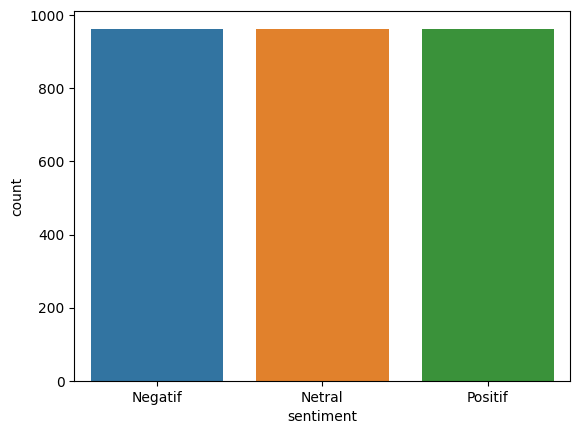

In [ ]:
# Membuat label dan jumlah label
labels = ['Negatif', 'Netral', 'Positif']

# Tampilkan grafik countplot
sns.countplot(x='sentiment', data=df_oversampled)

# Ubah keterangan pada sumbu x
plt.xticks([0, 1, 2], labels)

# Tampilkan grafik
plt.show()


# **Pemodelan**

## **1. Pembobotan Kata dengan TF-IDF**

Pada tahap ini dilakukan pembobotan kata dari hasil stemming dengan metode Term Inverse Document Frequency (TF-IDF).Metode TF-IDF digunakan untuk mengetahui seberapa sering suatu kata muncul di dalam dokumen. Tahap ini dibantu dengan library sklearn.

Hasil Nilai bobot TF-IDF

In [ ]:
# Membuat kolom 'Kata' dengan memisahkan setiap kalimat menjadi sebuah list of words
# (lambda x: x.split(','))= untuk memisahkan kalimat menjadi list kata kata berdasarkan koma
df_oversampled['Kata'] = df_oversampled['Stemming'].apply(lambda x: x.split(','))

# Membuat kolom 'Hitung' dengan menghitung jumlah kemunculan setiap kata
# (lambda x: {i: x.count(i) for i in x}) = untuk menghitung jumlah kemunculan setiap kata dalam list kata
# dan mengembalikan dic dg kata sbg kunci dan jumlah kemunculan brupa nilai
df_oversampled['TF-IDF'] = df_oversampled['Kata'].apply(lambda x: {i: x.count(i) for i in x})

# Membuat DataFrame baru untuk menampilkan data hasil penghitungan
# (list(df_oversampled['TF-IDF'])) = untuk mengubah kolom 'TF-IDF' menjadi list, kemudian list tersebut diubah menjadi DataFrame.
data_hitung_tf = pd.DataFrame(list(df_oversampled['TF-IDF'])).fillna(0)

# Menambahkan kolom 'Kalimat' ke dalam DataFrame hasil penghitungan
data_hitung_tf.insert(0, 'Kalimat', df_oversampled['Stemming'])
data_hitung_tf

,Kalimat,kali,ajak,anak,kesini,cocok,umur,diatas,th,dibawah,...,berat,menyenenangkan,mukin,ditingkatan,menggangu,silam,diterapkan,dipisah,pisah,jatuhnya
0,"kali,ajak,anak,kesini,cocok,anak,umur,diatas,t...",1.0,1.0,3.0,1.0,1.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"edu,wisata,keluarga,bawa,makanan,apapun,tikar,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"ramai,dipadati,pengunjung,keluarga,study,tour,...",0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"berkunjung,kbs,pakai,aplikasi,tiketwisata,sura...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"tiket,masuk,ribu,kepala,anak,diatas,usia,bayar...",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,"tiket,murah,cocok,pgn,zoo,date,xixi,hewannya,k...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2885,"kali,kebun,binatang,bersih,hewan,nya,terjamin,...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2886,"seru,tempatnya,luas,capek,jalan,kesana,uas,tug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2887,"pintu,masuk,parkir,liar,berbohong,bilang,parki...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# cetak data hitung term frequency
data_hitung_tf.to_excel('ulasan-kebun-binatang-term-frequency-dataoversampling.xlsx', index=False)

In [ ]:
# menghitung jumlah dokumen (kalimat) yang mengandung suatu kata tertentu dalam kolom 'Stemming' pada DataFrame.
def hitung_kalimat_sama(dataframe, kolom, kata):
    jumlah_kalimat = 0

    for kalimat in dataframe[kolom]:
        kalimat = kalimat.lower()
        if kata.lower() in kalimat:
            jumlah_kalimat += 1

    return jumlah_kalimat


hasil = []
for i in range(len(df_oversampled['Stemming'])):
  kata = []
  hasil.append(kata)
  for j in df_oversampled['Stemming'][i].lower().split(','):
    kata.append(j)

# print(hasil)
HasilPerhitungan = {'kata' : [], 'jumlah_dokumen' : []}
for i in range(len(hasil)):
  for j in range(len(hasil[i])):
    jumlah_kalimat = hitung_kalimat_sama(df_oversampled, 'Stemming', hasil[i][j])
    # print(f"Jumlah kalimat yang mengandung kata '{hasil[i][j]}': {jumlah_kalimat}")
    HasilPerhitungan['kata'].append(hasil[i][j])
    HasilPerhitungan['jumlah_dokumen'].append(jumlah_kalimat)
# print(HasilPerhitungan)
b = pd.DataFrame(HasilPerhitungan)
hasil_hitung_df_oversampling = b.drop_duplicates(subset=['kata'], keep='first')
hasil_hitung_df_oversampling = hasil_hitung_df_oversampling.reset_index(drop=True)
hasil_hitung_df_oversampling

,kata,jumlah_dokumen
0,kali,151
1,ajak,60
2,anak,702
3,kesini,349
4,cocok,226
...,...,...
2842,silam,1
2843,diterapkan,1
2844,dipisah,1
2845,pisah,2


In [ ]:
# hasil_hitung_df_oversampling.to_excel('ulasan-kebun-binatang-term-df-oversampling.xlsx', index=False)

In [ ]:
# mengubah hasil pembobotan dari data biasa ke array
dt_under = df_oversampled['Stemming']

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df_oversampled['Stemming'])
tf_idf_array = x.toarray()

# mendapatkan daftar kata dari proses TfidfVectorizer()
corpus = vectorizer.get_feature_names_out()
# mengubah corpus menjadi fitur dalam pembobotan tf idf
hasil_hitung_tfid_oversampling = pd.DataFrame(tf_idf_array, columns=corpus)
# menambahkan fitur kalimat yng berisi dokumen yang dilakukan pembobotan
hasil_hitung_tfid_oversampling.insert(0, 'Kalimat', dt_under)
lbl = df_oversampled['sentiment']
hasil_hitung_tfid_oversampling['sentiment'] = lbl
hasil_hitung_tfid_oversampling

,Kalimat,abah,abak,ac,acara,accessible,ada,ade,adem,ademm,...,years,yng,yuk,zaman,zebra,zona,zoo,zoonya,zoorabaya,sentiment
0,"kali,ajak,anak,kesini,cocok,anak,umur,diatas,t...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1
1,"edu,wisata,keluarga,bawa,makanan,apapun,tikar,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0
2,"ramai,dipadati,pengunjung,keluarga,study,tour,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1
3,"berkunjung,kbs,pakai,aplikasi,tiketwisata,sura...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1
4,"tiket,masuk,ribu,kepala,anak,diatas,usia,bayar...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,"tiket,murah,cocok,pgn,zoo,date,xixi,hewannya,k...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.27275,0.0,0.0,2
2885,"kali,kebun,binatang,bersih,hewan,nya,terjamin,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,2
2886,"seru,tempatnya,luas,capek,jalan,kesana,uas,tug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,2
2887,"pintu,masuk,parkir,liar,berbohong,bilang,parki...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,2


In [ ]:
# save model pada data undersampling
filenameTFIDF = 'tfidf_oversampling.pkl'
joblib.dump(vectorizer, filenameTFIDF)

['tfidf_oversampling.pkl']

## **2. Make Model SVM**

In [ ]:
Y = df_oversampled['sentiment']

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, Y, test_size=0.1, random_state=4)

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

# Membuat model SVM
model = SVC(kernel = 'linear', probability=True, gamma='auto', C=2)

# Training model
model.fit(x_train, y_train)

# Prediksi data testing
y_pred = model.predict(x_test)

In [ ]:
# Evaluasi model dengan data oversampling 
print ("Kernel = linear, Test size : 0.1, Random state = 4")
print(classification_report(y_test, y_pred))

Kernel = linear, Test size : 0.1, Random state = 4
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        86
           1       1.00      0.91      0.95       104
           2       1.00      1.00      1.00        99

    accuracy                           0.97       289
   macro avg       0.97      0.97      0.97       289
weighted avg       0.97      0.97      0.97       289



### **Penjelasan Output**
Output yang diberikan merupakan hasil dari pengukuran akurasi model klasifikasi pada data uji.

* Precision: Mencerminkan seberapa akurat model dalam mengidentifikasi positif. Dalam contoh ini, precision untuk kelas 0 adalah 0.68, yang berarti model benar dalam mengidentifikasi 68% dokumen yang termasuk ke dalam kelas 0.

* Recall: Mencerminkan seberapa baik model dalam menemukan semua contoh positif. Recall untuk kelas 0 adalah 1.00, yang berarti model dapat menemukan semua dokumen yang termasuk ke dalam kelas 0.

* F1-score: Mencerminkan keseimbangan antara precision dan recall. F1-score yang dihitung menggunakan precision dan recall untuk setiap kelas. Dalam contoh ini, F1-score untuk kelas 0 adalah 0.81, yang menunjukkan bahwa model memiliki keseimbangan yang baik antara precision dan recall.

* Support: Menunjukkan jumlah dokumen dalam setiap kelas.

* Accuracy: Menunjukkan persentase dokumen yang terklasifikasi dengan benar oleh model. Dalam contoh ini, akurasi model adalah 0.68 atau 68%.

* Macro avg: Menghitung rata-rata precision, recall, dan F1-score untuk semua kelas. Dalam contoh ini, rata-rata precision, recall, dan F1-score untuk semua kelas adalah rendah, yaitu 0.14, 0.20, dan 0.16.

* Weighted avg: Menghitung rata-rata precision, recall, dan F1-score dengan mempertimbangkan jumlah dokumen dalam setiap kelas. Dalam contoh ini, rata-rata precision, recall, dan F1-score untuk semua kelas adalah 0.46, 0.68, dan 0.54. Rata-rata weighted avg lebih baik daripada macro avg karena mempertimbangkan ketidakseimbangan jumlah dokumen dalam setiap kelas.

### **Confusion Matrix**

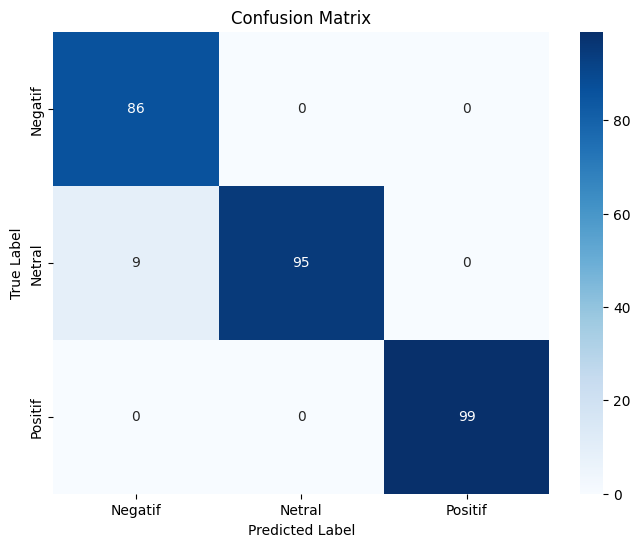

In [ ]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# print(y_test.shape)
# print(y_pred.shape)
labels = ['Negatif', 'Netral', 'Positif']

# Mengubah confusion matrix menjadi DataFrame untuk visualisasi
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### **Data Train Gagal Predict**

In [ ]:
# Menemukan indeks data yang salah diprediksi
misclassified_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

# Menampilkan data yang salah diprediksi
false_negatif = []
false_positif = []
false_netral = []
for index in misclassified_indices:
  text_data = np.array(vectorizer.inverse_transform(x_test[index])).tolist()
  text = ' '.join(text_data[0])
  true_label = labels[y_test[index]]
  predicted_label = labels[y_pred[index]]

  if predicted_label == 'Negatif':
    false_negatif.append([text, true_label, predicted_label])
  elif predicted_label == 'Netral':
    false_netral.append([text, true_label, predicted_label])
  else:
    false_positif.append([text, true_label, predicted_label])

print('False Negatif')
for negatif in false_negatif:
  print("Data:", negatif[0])
  print("True Label:", negatif[1])
  print("Predicted Label:", negatif[2])
  print("------"*20)
print('===='*30)
print()

print('False Netral')
for netral in false_netral:
  print("Data:", netral[0])
  print("True Label:", netral[1])
  print("Predicted Label:", netral[2])
  print("------"*20)
print('===='*30)
print()

print('False Positif')
for positif in false_positif:
  print("Data:", positif[0])
  print("True Label:", positif[1])
  print("Predicted Label:", positif[2])
  print("------"*20)

False Negatif
Data: banget dateng foto jam jasa kbs kelas kemarin kosong luas nawarin oke orang pagi parkirnya smp th umur
True Label: Netral
Predicted Label: Negatif
------------------------------------------------------------------------------------------------------------------------
Data: anak asri bagus binatang edukasi habitatnya hewan kebun koleksi lengkap lokasi masuk mengenal sarana satwanya sejuk strategis terjangkau tiket wisata
True Label: Netral
Predicted Label: Negatif
------------------------------------------------------------------------------------------------------------------------
Data: anak asri berubah ditengah kesini kota sdh surabaya tempatnya th umur wahana
True Label: Netral
Predicted Label: Negatif
------------------------------------------------------------------------------------------------------------------------
Data: anak edukasi jalan rekomendasi
True Label: Netral
Predicted Label: Negatif
--------------------------------------------------------------

### Predict

#### fungsi preprocessing
ini merupakan fungsi preprocessing yang di jadikan satu, dengan mengambil dari tahap-tahap sebelumnya

In [ ]:
def preprocessing_text(ulasan):
    def cleaning_ulasan(ulasan):
        ulasan = re.sub(r'@[A-Za-a0-9]+', ' ', ulasan)
        ulasan = re.sub(r'#[A-Za-z0-9]+', ' ', ulasan)
        ulasan = re.sub(r'http\S+', ' ', ulasan)
        ulasan = re.sub(r'[0-9]+', ' ', ulasan)
        ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
        ulasan = ulasan.strip(' ')
        return ulasan

    def tokenizing_text(ulasan):
        ulasan = word_tokenize(ulasan)
        return ulasan

    def convert_to_slangword(ulasan):
        kamus_slang = eval(open("/content/drive/MyDrive/Kuliah /Rimah/Dataset/slangwords.txt").read())
        pattern = re.compile(r'\b(' + '|'.join(kamus_slang.keys()) + r')\b')
        content = []
        for kata in ulasan:
            filter_slang = pattern.sub(lambda x: kamus_slang[x.group()], kata)
            content.append(filter_slang.lower())
        ulasan = content
        return ulasan

    def stopword_removal(words):
        daftar_stopword = stopwords.words('indonesian')
        # manualy add stopword
        daftar_stopword.extend(["yg", "dg", "rt"])
        daftar_stopword = set(daftar_stopword)
        return [word for word in words if word not in daftar_stopword]

    def stemming_text(document):
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        term_dict = {}

        for term in document:
            if term not in term_dict:
                term_dict[term] = ' '

        for term in term_dict:
            term_dict[term] = stemmer.stem(term)

        return ' '.join([term_dict[term] for term in document])

    # Cleaning
    ulasan = cleaning_ulasan(ulasan)

    # Tokenizing
    ulasan = tokenizing_text(ulasan)

    # Convert to slangword
    ulasan = convert_to_slangword(ulasan)

    # Stopword removal
    ulasan = stopword_removal(ulasan)

    # Stemming
    ulasan = stemming_text(ulasan)

    return ulasan

#### Membuat Data baru

data dengan preprocessing

In [ ]:
ulasan = pd.DataFrame([
    'Kebun binatang ini sangat mengecewakan. Kandang-kandangnya terlihat kotor dan tidak terawat. Hewan-hewannya juga terlihat sedih dan kurang perhatian. Saya tidak akan merekomendasikan tempat ini kepada siapa pun',
    'Kebun binatang ini cukup standar. Tidak ada yang istimewa, tetapi juga tidak ada yang buruk. Hewan-hewannya tampak sehat dan lingkungannya cukup bersih. Bagi saya, pengalaman di sini biasa saja',
    'Saya sangat senang mengunjungi kebun binatang ini! Tempat ini memiliki beragam koleksi hewan yang menakjubkan. Kandang-kandangnya terlihat rapi dan bersih. Stafnya juga sangat ramah dan membantu. Saya sangat merekomendasikan tempat ini untuk dikunjungi oleh keluarga'])

preprocessed_ulasan = ulasan[0].apply(preprocessing_text)

Data tanpa preprocessing

In [ ]:
data_tanpa_prep = [
    'Kebun binatang ini sangat mengecewakan. Kandang-kandangnya terlihat kotor dan tidak terawat. Hewan-hewannya juga terlihat sedih dan kurang perhatian. Saya tidak akan merekomendasikan tempat ini kepada siapa pun',
    'Kebun binatang ini cukup standar. Tidak ada yang istimewa, tetapi juga tidak ada yang buruk. Hewan-hewannya tampak sehat dan lingkungannya cukup bersih. Bagi saya, pengalaman di sini biasa saja',
    'Saya sangat senang mengunjungi kebun binatang ini! Tempat ini memiliki beragam koleksi hewan yang menakjubkan. Kandang-kandangnya terlihat rapi dan bersih. Stafnya juga sangat ramah dan membantu. Saya sangat merekomendasikan tempat ini untuk dikunjungi oleh keluarga']

Hasil Predict

In [ ]:
load_vec = joblib.load('tfidf_oversampling.pkl')
class_name = ['Negatif', 'Netral', 'Positif']

x_tanpa_prep = load_vec.transform(data_tanpa_prep)
x_dengan_prep = load_vec.transform(preprocessed_ulasan)

prediction_tp = model.predict(x_tanpa_prep)
prediction_dp = model.predict(x_dengan_prep)

print('Hasil Predict Data Baru tanpa Preprocessing')
for i in prediction_tp:
  print(class_name[i])

print('='*20)

print('Hasil Predict Data Baru dengan Preprocessing')
for i in prediction_dp:
  print(class_name[i])

Hasil Predict Data Baru tanpa Preprocessing
Netral
Netral
Netral
Hasil Predict Data Baru dengan Preprocessing
Netral
Netral
Negatif
